In [29]:
import numpy as np
import matplotlib.pyplot as plt 
eps = 0.000001
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

value: 3.625
p: [0.625 0.375 0.    0.    0.   ]
q: [0.875 0.125 0.   ]


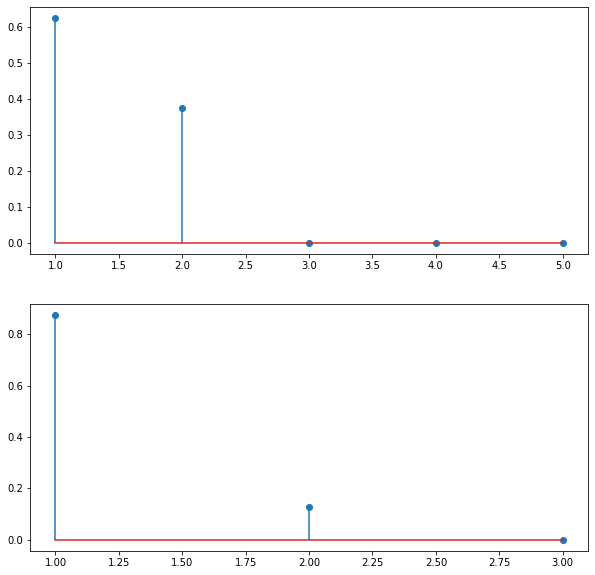

In [33]:
arr1 = np.array([
    [4,1,6],
    [3,8,4],
    [3,8,1],
    [3,8,0],
    [3,8,2]
])
p, q, value = nash_equilibrium(arr1)
print('value:', value)
print('p:', p)
print('q:', q)
print_res(p,q)

value: 4.5
p: [0.  0.5 0.5]
q: [0.167 0.833]


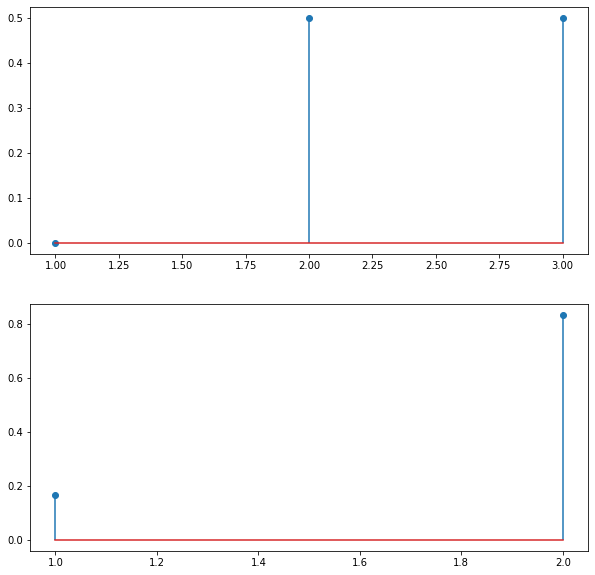

In [31]:
arr = np.array([[1,3],
               [2,5],
               [7,4]
               ])

p, q, value = nash_equilibrium(arr)
print('value:', value)
print('p:', p)
print('q:', q)
print_res(p,q)

value: 3.8888888888888884
p: [0.286 0.373 0.    0.    0.04  0.302]
q: [0.611 0.167 0.167 0.056]


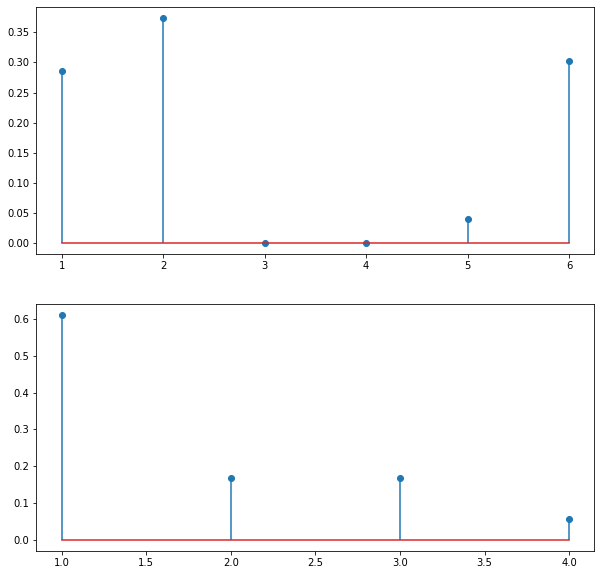

In [32]:
arr3 = np.array([
        [4,1,6,5],
        [3,8,4,1],
        [3,8,1,3],
        [3,8,0,9],
        [3,8,2,7],
        [5,1,2,6]
    ])
p, q, value = nash_equilibrium(arr3)
print('value:', value)
print('p:', p)
print('q:', q)
print_res(p,q)

In [2]:
def nash_equilibrium(arr):
    row_clean_ind, col_clean_ind = clean_str(arr)   #поиск седловой точки; 
    p = np.empty(len(arr), dtype = float)
    q = np.empty(len(arr[0]), dtype = float)
    if row_clean_ind != -1 and col_clean_ind != -1:   #найдено оптимальное решение в чистых стратегиях
        p = p.astype('int')
        q = q.astype('int')
        for i in range(0, len(arr)):
            p[i] = 1 if i==row_clean_ind else 0
            q[i] = 1 if i==col_clean_ind else 0
        return p, q, arr[row_clean_ind,col_clean_ind]
    else:   # поиск в смешанных
        simplex_table, base, zmax = simplex_matrix(arr)   #получение исходной симплексной таблицы
        jpivot = check_z(zmax)

        while jpivot > 0:
            ipivot = get_pivot(simplex_table, jpivot)
            change_base(base,ipivot,jpivot)
            change_table(simplex_table, zmax, base, ipivot, jpivot)
            jpivot = check_z(zmax)
        getres(zmax, base, simplex_table, p, q)
        return p, q, 1/zmax[0]



In [3]:

def clean_str(a):
    rowmin = np.empty(len(a), dtype=float)
    for i in range(0, len(a)):
        rowmin[i] = a[i,0]
    colsmax = np.empty(len(a[0]), dtype=float)
    for j in range(0, len(a[0])):
        colsmax[j] = a[0,j]
        
    for i in range(0, len(a)):
        for j in range(0, len(a[0])):
            if a[i,j] < rowmin[i]:
                rowmin[i] = a[i,j]
            if a[i,j] > colsmax[j]:
                colsmax[j] = a[i,j]
                
    highvalue = colsmax[0]  # верхняя цена игры 
    lowvalue = rowmin[0]  # нижняя цена игры
    highind = 0
    lowind = 0  # их индексы (номера стратегий)
    for i in range(1, len(a)):
        if rowmin[i] > lowvalue:
            lowvalue = rowmin[i]
            lowind = i
    for j in range(1, len(a[0])):
        if colsmax[j] < highvalue:
            highvalue = colsmax[j]
            highind = j

    if (highvalue - lowvalue) < eps:  # проверка на существование седловой точки -> чистых стратегий
        return lowind, highind
    return -1, -1


In [4]:
def simplex_matrix(arr):   
    init_simplex_table = np.empty((len(arr), len(arr[0]) + len(arr) + 1), dtype = float)
    base = np.empty(len(arr[0]) + len(arr), dtype=int)
    zmax = np.empty(len(arr[0]) + len(arr) + 1, dtype=float)
    for i in range(0, len(zmax)):
        if i == 0:
            zmax[i] = 0
        elif i <= len(arr[0]):
            zmax[i] = -1
        else: 
            zmax[i] = 0
    for i in range(0, len(base)):
        base[i] = -1 if i < len(arr[0]) else i - len(arr[0])

    for i in range(0, len(init_simplex_table)):  
        for j in range(0, len(init_simplex_table[0])):
            if j == 0:
                init_simplex_table[i,j] = 1
            elif j <= len(arr[0]):
                init_simplex_table[i,j] = arr[i, j - 1]
            elif j - len(arr[0]) - 1 == i:
                init_simplex_table[i,j] = 1
            else: 
                init_simplex_table[i,j] = 0
    return init_simplex_table, base, zmax



In [5]:
def check_z(zmax):
    max = 0
    max_j = -1
    g=0
    for i in range(1, len(zmax)):
        if abs(zmax[i]) >= max and (zmax[i] < 0):
            max = abs(zmax[i])
            max_j = i
        if zmax[i] < 0:
            g = 1
    if g:
        return max_j
    return -1

In [6]:
def get_pivot(arr, c):
    j = 0
    while arr[j, c] <= 0:
        j += 1
    min = arr[j,0] / arr[j,c] + 1
    row = -1
    for i in range(0, len(arr)):
        if arr[i,c] > 0:
            temp = arr[i,0]/arr[i,c]
            if temp < min - eps:
                min = temp
                row = i
    return row

In [7]:
def change_base(base,ipivot,jpivot):
    base[base == ipivot] =- 1
    base[jpivot - 1] = ipivot
    return base   

In [8]:
def change_table(simplex_table, zmax, base, ipivot, jpivot):
    pivot = simplex_table[ipivot, jpivot]   #преобразование матрицы
    simplex_table[ipivot] = simplex_table[ipivot,:] / pivot
    for i in range(simplex_table.shape[0]):
        if i != ipivot:
            k = simplex_table[i, jpivot]
            simplex_table[i] -= k * simplex_table[ipivot]
            simplex_table[i,jpivot] = 0
      
    z_jpivot = zmax[jpivot]   #преобразование zmax
    zmax -= z_jpivot * simplex_table[ipivot] 
    return 0       

In [9]:
def getres(zmax, base, arr, p, q):
    for i in range(0, len(p)):
        p[i] = zmax[i + len(q) + 1]/zmax[0]
    for i in range(0, len(q)):
        q[i] = 0 if base[i] == -1 else arr[base[i], 0]/zmax[0]

In [12]:
def print_res(p,q):
    x1 = np.linspace(1, len(p), len(p)) 
    x2 = np.linspace(1, len(q), len(q)) 
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.stem(x1, p, use_line_collection=True)
    plt.subplot(2,1,2)
    plt.stem(x2, q, use_line_collection=True)